[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  1 of 1 completed


--------------------------------------------------
 [최종 성과 리포트] 
 전략명: 저변동성 + 모멘텀 (월간 리밸런싱)
--------------------------------------------------
 1. 총 수익률      :  349.66% (시장: 29.68%)
 2. 초과 수익률    :  319.98%p
--------------------------------------------------


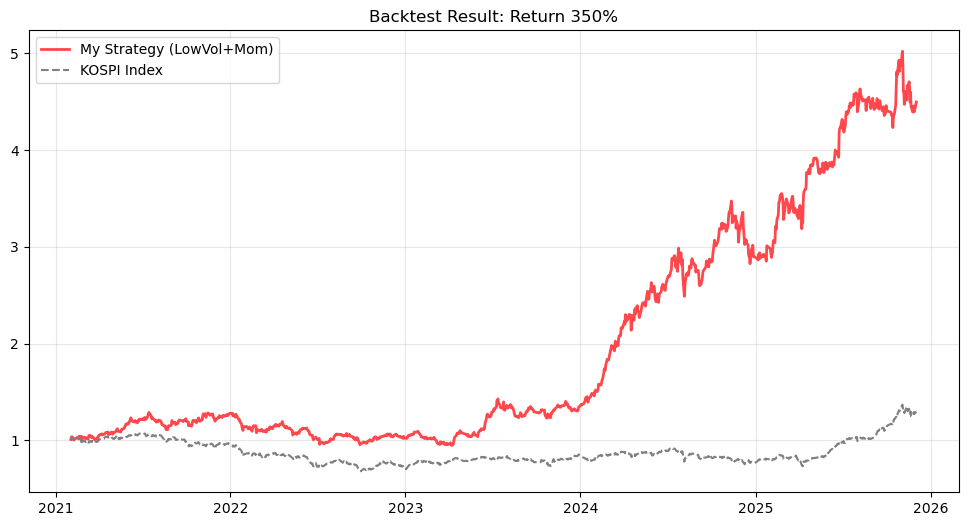

In [3]:
# 라이브러리
import pandas as pd
import numpy as np
import yfinance as yf
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# 1. 데이터 수집(2022~)
df_krx = fdr.StockListing('KOSPI')
top50_df = df_krx.sort_values('Marcap', ascending=False).head(50)

tickers = [code + ".KS" for code in top50_df['Code']]

  # 종목 주가 데이터
data_raw = yf.download(tickers, start="2020-01-01")
data = data_raw['Close']

  # 시장 지수 데이터
kospi_raw = yf.download('^KS11', start="2020-01-01")
data_ks = kospi_raw['Close']

if data_ks.ndim > 1:
    data_ks = data_ks.iloc[:, 0]

# 2. 전략 생성
def select_top5_stocks(price_data, market_data):
    """
    과거 1년치 데이터를 받아 저변동성+모멘텀 상위 5개 종목을 선정 함수
    """
    # 수익률 정의
    daily_ret = price_data.pct_change(fill_method=None).dropna()
    mkt_ret = market_data.pct_change(fill_method=None).dropna()
    
    common_index = daily_ret.index.intersection(mkt_ret.index)
    daily_ret = daily_ret.loc[common_index]
    mkt_ret = mkt_ret.loc[common_index]

    # 데이터프레임 여부 확인
    if isinstance(mkt_ret, pd.DataFrame):
        mkt_ret = mkt_ret.iloc[:, 0]
        
    # 베타
    market_var = mkt_ret.var()
    beta = daily_ret.apply(lambda x: x.cov(mkt_ret) / market_var)
    
    # 모멘텀
    momentum = (price_data.iloc[-1] / price_data.iloc[0]) - 1
    
    rank_beta = beta.rank(ascending=True)
    rank_mom = momentum.rank(ascending=False)
    total_score = rank_beta + rank_mom
    
    # 선정
    return list(total_score.sort_values().head(5).index)

# 3. 백테스팅

returns = data.pct_change(fill_method=None)

monthly_returns = []

rebal_dates = data.resample('ME').last().index

for i in range(12, len(rebal_dates) - 1):
    
    today = rebal_dates[i]
    next_month = rebal_dates[i+1]
    past_prices = data.loc[:today].tail(252)
    past_market = data_ks.loc[:today].tail(252)
    selected_tickers = select_top5_stocks(past_prices, past_market)
    period_return = returns[selected_tickers].loc[today:next_month].iloc[1:]
    avg_return = period_return.mean(axis=1)
    monthly_returns.append(avg_return)
portfolio_daily_returns = pd.concat(monthly_returns)

# 누적 수익률
my_wealth = (1 + portfolio_daily_returns).cumprod()
market_wealth = (1 + data_ks.pct_change(fill_method=None).loc[my_wealth.index]).cumprod()

final_ret = (my_wealth.iloc[-1] - 1) * 100
market_final_ret = (market_wealth.iloc[-1] - 1) * 100

print("-" * 50)
print(f" [최종 성과 리포트] ")
print(f" 전략명: 저변동성 + 모멘텀 (월간 리밸런싱)")
print("-" * 50)
print(f" 1. 총 수익률      : {final_ret: .2f}% (시장: {market_final_ret:.2f}%)")
print(f" 2. 초과 수익률    : {final_ret - market_final_ret: .2f}%p")
print("-" * 50)

plt.figure(figsize=(12, 6))
plt.plot(my_wealth, label='My Strategy (LowVol+Mom)', color='blue', linewidth=2)
plt.plot(market_wealth, label='KOSPI Index', color='gray', linestyle='--')
plt.title(f'Backtest Result: Return {final_ret:.0f}%')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()